<a href="https://colab.research.google.com/github/TroyWorkPublic/tibaml0922/blob/main/transfer_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
f = zipfile.ZipFile("/content/drive/MyDrive/additional/train.zip")
f.extractall()

FileNotFoundError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import glob
import pandas as pd 
good = glob.glob("/content/drive/MyDrive/poo_p/poo_*")
bad = glob.glob("/content/drive/MyDrive/bad_poo_p/bad_poo_*")
df = pd.DataFrame({
    "path":good + bad,
    "ans":[0] * len(good) + [1] * len(bad)
})
df

,path,ans
0,/content/drive/MyDrive/poo_p/poo_p (843).jpg,0
1,/content/drive/MyDrive/poo_p/poo_p (850).jpg,0
2,/content/drive/MyDrive/poo_p/poo_p (847).jpg,0
3,/content/drive/MyDrive/poo_p/poo_p (846).jpg,0
4,/content/drive/MyDrive/poo_p/poo_p (849).jpg,0
...,...,...
1223,/content/drive/MyDrive/bad_poo_p/bad_poo_p (98...,1
1224,/content/drive/MyDrive/bad_poo_p/bad_poo_p (97...,1
1225,/content/drive/MyDrive/bad_poo_p/bad_poo_p (96...,1
1226,/content/drive/MyDrive/bad_poo_p/bad_poo_p (95...,1


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization
cnn = VGG16(include_top=False, input_shape=(224, 224, 3))
for l in cnn.layers:
    l.trainable = False
layers = [
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(2, activation="softmax")
]
model = Sequential(cnn.layers + layers)
model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________

In [ ]:
# y: 做one-hot encoding很耗費ram, 直接使用Sparse省RAM又方便
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer="adam",
              metrics=["accuracy"])

[[[ 62.060997   68.221      19.32     ]
  [ 79.061      87.221      33.32     ]
  [ 92.061     108.221      47.32     ]
  ...
  [ 31.060997   53.221     -13.68     ]
  [ 45.060997   66.221       5.3199997]
  [ 54.060997   71.221      18.32     ]]

 [[ 36.060997   43.221      -2.6800003]
  [ 80.061      89.221      39.32     ]
  [100.061     114.221      57.32     ]
  ...
  [ 62.060997   84.221      22.32     ]
  [ 56.060997   76.221      20.32     ]
  [ 49.060997   65.221      14.32     ]]

 [[ 30.060997   41.221      -3.6800003]
  [ 86.061      98.221      50.32     ]
  [ 94.061     109.221      55.32     ]
  ...
  [ 55.060997   76.221      22.32     ]
  [ 39.060997   56.221       6.3199997]
  [ 29.060997   43.221      -3.6800003]]

 ...

 [[ 47.060997   66.221      54.32     ]
  [  9.060997   21.221      11.32     ]
  [-10.939003   -8.778999  -20.68     ]
  ...
  [ 14.060997   21.221     -25.68     ]
  [-14.939003  -12.778999  -52.68     ]
  [-54.939003  -57.779     -90.68     ]]

 [

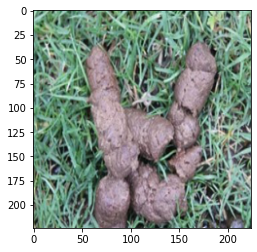

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

p = df["path"]
idx = random.randint(0, len(p)-1)
img = Image.open(p[idx]).resize((224, 224)).convert("RGB")
img_np = np.array(img)
img_np_pre = preprocess_input(img_np)
print(img_np_pre)
plt.imshow(img)

In [ ]:
x = np.array(df["path"])
y = np.array(df["ans"])

In [ ]:
def data_generator(x, y, batch_size=20):
    while True:
        idx = np.random.randint(0, len(x), size=batch_size)
        x_batch, y_batch = x[idx], y[idx]
        x_final = []
        for path in x_batch:
            img = Image.open(path).resize((224, 224)).convert("RGB")
            img_pre = preprocess_input(np.array(img))
            x_final.append(img_pre)
        x_final = np.array(x_final)
        y_batch = np.array(y_batch)
        yield (x_final, y_batch)
gen = data_generator(x, y)
x_gen, y_gen = gen.__next__()
print(x_gen.shape)
print(y_gen.shape)
# print(x_gen)
# print(y_gen)

(20, 224, 224, 3)
(20,)


In [ ]:
from sklearn.model_selection import train_test_split
goodx = x[y == 0]
badx = x[y == 1]
good120 = np.random.choice(goodx, 1100, replace=False)
good900, good100 = train_test_split(good120, test_size=0.15)
bad100 = np.random.choice(badx, 90, replace=False)
bad100, bad10 = train_test_split(bad100, test_size=0.1)
x_train = np.concatenate((good900, bad100))
y_train = np.array([0] * len(good900) + [1] * len(bad100))
x_test = np.concatenate((good100, bad10))
y_test = np.array([0] * len(good100) + [1] * len(bad10))
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1016,)
(174,)
(1016,)
(174,)


In [ ]:
train_generator = data_generator(x_train, y_train)
test_generator = data_generator(x_test, y_test)

In [ ]:
# 50 * 20 -> 訓練
# 5 * 20 -> 測試
model.fit_generator(train_generator,  #steps_per_epoch=每次美45張*上面的batch_size數量
                    steps_per_epoch=45,
                    #跑幾次訓練
                    epochs=5,
                    validation_data=test_generator,
                    validation_steps=5)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
45/45 [==============================] - 677s 15s/step - loss: 0.2123 - accuracy: 0.9233 - val_loss: 0.1431 - val_accuracy: 0.9500
Epoch 2/5
45/45 [==============================] - 669s 15s/step - loss: 0.1739 - accuracy: 0.9400 - val_loss: 0.1116 - val_accuracy: 0.9700
Epoch 3/5
45/45 [==============================] - 654s 15s/step - loss: 0.1513 - accuracy: 0.9444 - val_loss: 0.0757 - val_accuracy: 0.9900
Epoch 4/5
45/45 [==============================] - 661s 15s/step - loss: 0.1548 - accuracy: 0.9367 - val_loss: 0.0654 - val_accuracy: 0.9900
Epoch 5/5
45/45 [==============================] - 658s 15s/step - loss: 0.1268 - accuracy: 0.9600 - val_loss: 0.1126 - val_accuracy: 0.9500


In [ ]:
testx, testy = test_generator.__next__()
model.predict(testx)

array([[9.97418046e-01, 2.58199824e-03],
       [7.42452741e-01, 2.57547259e-01],
       [9.94795859e-01, 5.20417141e-03],
       [9.95058894e-01, 4.94113332e-03],
       [9.99778211e-01, 2.21816183e-04],
       [8.70858788e-01, 1.29141271e-01],
       [9.09966111e-01, 9.00338739e-02],
       [9.99170423e-01, 8.29555967e-04],
       [9.56987202e-01, 4.30128388e-02],
       [9.71713006e-01, 2.82869432e-02],
       [9.02974725e-01, 9.70252380e-02],
       [8.91033292e-01, 1.08966716e-01],
       [9.96104360e-01, 3.89561080e-03],
       [9.83826697e-01, 1.61733683e-02],
       [9.99917984e-01, 8.20358036e-05],
       [9.88070607e-01, 1.19293956e-02],
       [9.58248734e-01, 4.17513102e-02],
       [9.86087620e-01, 1.39123444e-02],
       [9.78273392e-01, 2.17266567e-02],
       [9.96104360e-01, 3.89561267e-03]], dtype=float32)

In [ ]:
ori_imgs = []
for p in x_test:
    img = Image.open(p).resize((224, 224)).convert("RGB")
    ori_imgs.append(np.array(img))
ori_imgs = np.array(ori_imgs)
preprocess_imgs = preprocess_input(ori_imgs)
pre = model.predict(preprocess_imgs).argmax(axis=1)

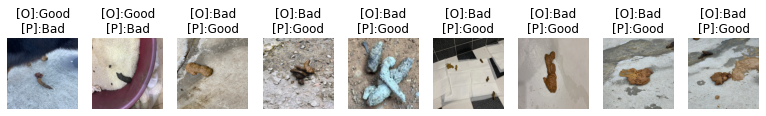

In [ ]:
trans = ["Good", "Bad"]
idx = np.nonzero(pre != y_test)[0]
pre_false_img = ori_imgs[idx]
pre_false_val = pre[idx]
pre_false_ori = y_test[idx]

plt.figure(figsize=(15, 15))
width = 10
height = len(idx) // width + 1
for i in range(len(idx)):
    plt.subplot(height, width, i+1)
    t = "[O]:{}\n[P]:{}".format(trans[pre_false_ori[i]],
                                trans[pre_false_val[i]])
    plt.title(t)
    plt.axis("off")
    plt.imshow(pre_false_img[i])


Enter:https://pic.pimg.tw/hdouzih/417af6ffa9b8efe44485861b48e67c01.jpg


/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


預測: Bad
機率: [0.05483825 0.9451617 ]


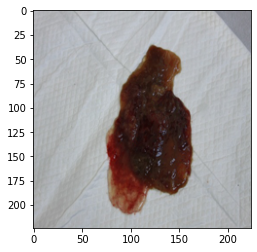

In [ ]:
import requests
url = input("Enter:")
response = requests.get(url, stream=True, verify=False)
img = Image.open(response.raw).resize((224, 224)).convert("RGB")
img_np = preprocess_input(np.array(img).reshape(1, 224, 224, 3))
proba = model.predict(img_np)
ans = proba.argmax(axis=1)
print("預測:", trans[ans[0]])
print("機率:", proba[0])
plt.imshow(img)

In [ ]:
model.save("Poop2.h5")